This is a conversion into notebook format of the script `reservoirs_lshm.simulate.py`.

Description:

```Text
Run the reservoir routine with default parameters.
```

In [1]:
# Path to the configuration file
CONFIG_FILE = 'Z:/nahaUsers/casadje/datasets/reservoirs/ResOpsUS/v2.1/results/linear/linear_2var.yml' # './camaflood_2var.yml'
# Overwrite existing simulation file
OVERWRITE = False

In [2]:
# %load ../../../src/reservoirs_lshm/simulate.py
#!/usr/bin/env python3

import argparse
import logging
import yaml
import pickle
from pathlib import Path

import pandas as pd
from tqdm import tqdm
from datetime import datetime

from reservoirs_lshm import Config, read_attributes, read_timeseries
from reservoirs_lshm.models import get_model, default_attributes
from reservoirs_lshm.utils.metrics import compute_performance
from reservoirs_lshm.utils.timeseries import create_demand
from reservoirs_lshm.utils.plots import plot_resops
from reservoirs_lshm.utils.logging import setup_logger

In [3]:
# === Configuration ===

# read configuration file
cfg = Config(CONFIG_FILE) #Config(args.config_file)
    
# set up logger
logger = setup_logger(
    name=__name__,
    log_level=logging.INFO,
    log_file=None #f'{datetime.now():%Y%m%d%H%M}_simulate_{cfg.MODEL}.log'
)

logger.info(f'Default simulation results will be saved in: {cfg.PATH_DEF}')

2025-05-19 14:19:34 | INFO | __main__ | Default simulation results will be saved in: Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsUS\v2.1\results\linear\default


In [4]:
# === Load reservoir list ===
try:
    reservoirs = pd.read_csv(cfg.RESERVOIRS_FILE, header=None).squeeze().tolist()
except IOError:
    logger.exception(f'Failed to open {cfg.RESERVOIRS_FILE}')
    raise

In [5]:
# === Load attributes ===
try:
    attributes = read_attributes(cfg.PATH_DATA / 'attributes', reservoirs)
    logger.info(f'{attributes.shape[0]} reservoirs in the attribute tables')
except IOError:
    logger.exception('Failed to read attribute tables from {0}'.format(cfg.PATH_DATA / 'attributes'))
    raise

2025-05-19 14:19:40 | INFO | __main__ | 195 reservoirs in the attribute tables


In [6]:
# === Load time periods ===
try:
    with open(cfg.PERIODS_FILE, 'rb') as file:
        periods = pickle.load(file)
except IOError:
    logger.exception(f'Failed to open {cfg.PERIODS_FILE}')
    raise

In [7]:
# === read time series ===
try:
    inputs = [var for var in [cfg.INFLOW, cfg.PRECIPITATION, cfg.EVAPORATION, cfg.DEMAND] if var]
    outputs = ['storage', 'outflow']
    timeseries = read_timeseries(
        path=cfg.PATH_DATA / 'time_series' / 'csv',
        reservoirs=attributes.index,
        periods=periods,
        variables=inputs + outputs
    )
    logger.info(f'{len(timeseries)} reservoirs with timeseries')
except IOError:
    logger.exception('Failed to read time series from {0}: {1}'.format(cfg.PATH_DATA / 'time_series' / 'csv'))
    raise

  0%|          | 0/195 [00:00<?, ?it/s]

2025-05-19 14:20:54 | INFO | __main__ | 195 reservoirs with timeseries


In [9]:
ts = timeseries[132]

In [10]:
ts.storage.first_valid_index(), ts.outflow.first_valid_index()

(Timestamp('1985-01-01 00:00:00'), Timestamp('1987-01-05 00:00:00'))

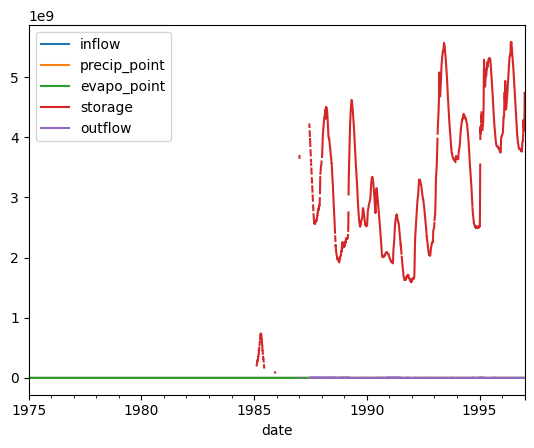

In [11]:
ts.plot();

In [ ]:
# === Simulate reservoir routine ===
for grand_id, ts in tqdm(timeseries.items(), desc='simulating reservoir'):

In [27]:
grand_id = 203
ts = timeseries[grand_id]

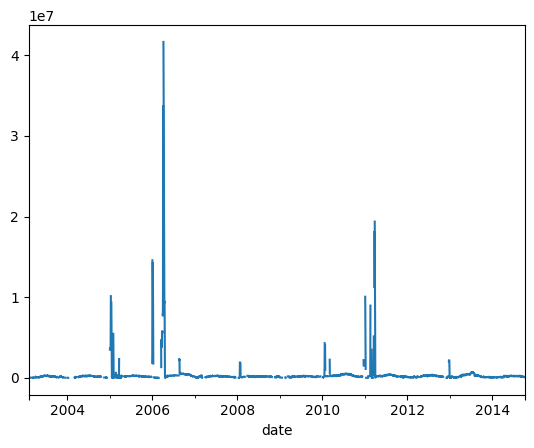

In [29]:
ts.storage.plot();

In [32]:
Vo = ts.storage.iloc[0]

In [33]:
pd.isna(Vo)

True

In [41]:
    out_file = cfg.PATH_DEF / f'{grand_id}_simulation.csv'
    if out_file.exists() and not OVERWRITE: #args.overwrite:
        logger.info(f'Simulation already exists for reservoir {grand_id}, skipping (use --overwrite to force)')
        # continue
        
    logger.info(f'Simulating reservoir {grand_id}')
    
    # define input time series
    inflow = ts[cfg.INFLOW]
    precipitation = ts[cfg.PRECIPITATION] if cfg.PRECIPITATION in ts.columns else None
    evaporation = ts[cfg.EVAPORATION] if cfg.EVAPORATION in ts.columns else None
    demand = ts[cfg.DEMAND] if cfg.DEMAND in ts.columns else None
    if cfg.MODEL == 'mhm':
        bias = ts.outflow.mean() / inflow.mean()
        demand = create_demand(
            ts.outflow,
            water_stress=min(1, bias),
            window=28
        )
        
    # plot observed time series
    try:
        path_obs = cfg.PATH_DEF.parent.parent / 'observed'
        path_obs.mkdir(exist_ok=True)
        plot_resops(
            storage=ts.storage,
            elevation=ts.elevation if 'elevation' in ts.columns else None,
            inflow=inflow,
            outflow=ts.outflow,
            capacity=attributes.loc[grand_id, 'CAP_MCM'] * 1e6,
            title=grand_id,
            save=path_obs / f'{grand_id}_line.jpg'
        )
        logger.info(f'Line plot of observations from reservoir {grand_id}')
    except IOError:
        logger.exception(f'The line plot of observed records could not be generated')
    
    # estimate default parameters
    try:
        Vtot = ts.storage.max()
        reservoir_attrs = default_attributes(
            cfg.MODEL,
            inflow,
            Vtot,
            Vmin=max(0, min(0.1 * Vtot, ts.storage.min())),
            Qmin=max(0, ts.outflow.min()),
            catchment=int(attributes.loc[grand_id, 'CATCH_SKM'] * 1e6),
            Atot=int(attributes.loc[grand_id, 'AREA_SKM'] * 1e6),
            storage=ts.storage,
            demand=demand
        ) 
    except RuntimeError:
        logger.exception(f'Default parameters for reservoir {grand_id} could not be estimated')
        # continue

    # simulation with default parameters
    try:
        # declare the reservoir
        res = get_model(cfg.MODEL, **reservoir_attrs)

        # export default parameters
        with open(cfg.PATH_DEF / f'{grand_id}_default_parameters.yml', 'w') as file:
            yaml.dump(res.get_params(), file)

        # simulate the reservoir
        Vo = ts.storage.iloc[0]
        Vo = None if pd.isna(Vo) else Vo
        sim_def = res.simulate(
            inflow=inflow,
            Vo=Vo,
            precipitation=precipitation,
            evaporation=evaporation,
            demand=demand,
        )
        sim_def.to_csv(cfg.PATH_DEF / f'{grand_id}_simulation.csv', float_format='%.3f')

        logger.info(f'Reservoir {grand_id} correctly simulated')

    except RuntimeError:
        logger.exception(f'Reservoir {grand_id} could not be simulated')
        # continue

2025-05-20 13:00:26 | INFO | __main__ | Simulating reservoir 203
2025-05-20 13:00:26 | INFO | __main__ | Line plot of observations from reservoir 203


timesteps:   0%|          | 0/4264 [00:00<?, ?it/s]

2025-05-20 13:00:27 | INFO | __main__ | Reservoir 203 correctly simulated


In [ ]:
    # === Analyse results ===
    
    # performance
    try:
        performance_def = compute_performance(ts.iloc[cfg.SPINUP:], sim_def.iloc[cfg.SPINUP:])
        performance_def.to_csv(cfg.PATH_DEF / f'{grand_id}_performance.csv', float_format='%.3f')
        logger.info(f'Performance of reservoir {grand_id} has been computed')
    except IOError:
        logger.exception(f'The performance of reservoir {grand_id} could not be exported')
    
    # scatter plot simulation vs observation
    try:
        res.scatter(
            sim_def,
            ts,
            norm=False,
            spinup=cfg.SPINUP,
            title=f'grand_id: {grand_id}',
            save=cfg.PATH_DEF / f'{grand_id}_scatter_obs_sim.jpg'
        )
        logger.info(f'Scatter plot of simulation from reservoir {grand_id}')
    except IOError:
        logger.exception(f'The scatter plot of reservoir {grand_id} could not be generated')
    
    # line plot simulation vs observation
    try:
        res.lineplot(
            {
            'sim': sim_def
            },
            ts,
            spinup=cfg.SPINUP,
            figsize=(12, 6),
            save=cfg.PATH_DEF / f'{grand_id}_line_obs_sim.jpg'
        )
        logger.info(f'Line plot of simulation from reservoir {grand_id}')
    except IOError:
        logger.exception(f'The line plot of reservoir {grand_id} could not be generated')

    del res, sim_def, reservoir_attrs, performance_def

2025-05-19 14:23:53 | INFO | __main__ | Simulating reservoir 132
2025-05-19 14:23:53 | INFO | __main__ | Line plot of observations from reservoir 132


SyntaxError: 'continue' not properly in loop (863620158.py, line 54)